In [64]:
import argparse
import numpy as np
from chainer import datasets, cuda, serializers, Variable
from chainer import optimizers as O
from chainer import functions as F
from models import Generator, Discriminator


# def rnd_categorical(n, n_categorical):
#     indices = np.random.randint(n_categorical, size=n)
#     one_hot = np.zeros((n, n_categorical))
#     one_hot[np.arange(n), indices] = 1
#     return one_hot, indices


def rnd_categorical(n, n_categorical):
    indices = np.random.randint(n_categorical, size=n)
    one_hot = np.zeros((n, n_categorical-12))
    for i in range(n):
        if indices[i]==15:
            one_hot[i, :]=[0,0,0,0]
        elif indices[i]==14:
            one_hot[i, :]=[0,0,0,1]
        elif indices[i]==13:
            one_hot[i, :]=[0,0,1,0]
        elif indices[i]==12:
            one_hot[i, :]=[0,1,0,0]
        elif indices[i]==11:
            one_hot[i, :]=[1,0,0,0]
        elif indices[i]==10:
            one_hot[i, :]=[0,0,1,1]
        elif indices[i]==9:
            one_hot[i, :]=[0,1,0,1]
        elif indices[i]==8:
            one_hot[i, :]=[1,0,0,1]
        elif indices[i]==7:
            one_hot[i, :]=[0,1,1,0]
        elif indices[i]==6:
            one_hot[i, :]=[1,0,1,0]
        elif indices[i]==5:
            one_hot[i, :]=[1,1,0,0]
        elif indices[i]==4:
            one_hot[i, :]=[0,1,1,1]
        elif indices[i]==3:
            one_hot[i, :]=[1,1,0,1]
        elif indices[i]==2:
            one_hot[i, :]=[1,0,1,1]
        elif indices[i]==1:
            one_hot[i, :]=[1,1,1,0]
        elif indices[i]==0:
            one_hot[i, :]=[1,1,1,1]
    return one_hot, indices


def rnd_continuous(n, n_continuous, mu=0, std=1):
    return np.random.normal(mu, std, size=(n, n_continuous))


if __name__ == '__main__':
    #args = parse_args()
    #gpu = args.gpu
    n_z = 0
    n_categorical = 16
    n_continuous = 2
    max_epochs = 10000
    batch_size = 1000
    #out_generator_filename = args.out_generator_filename

    # Prepare the training data
#     train, _ = datasets.get_mnist(withlabel=False, ndim=2)
#     train_size = train[0:1000].shape[0]
#     im_shape = train.shape[1:]
    
    import scipy.io as sio
    image = sio.loadmat('cross_ten28_vary.mat')
    data1=np.abs(image['final_img'])
    train=data1/1.
    train=train.reshape(10000,28,28)
    train_size = train[0:10000].shape[0]
    im_shape = train.shape[1:]


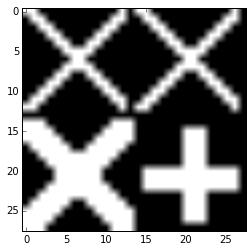

In [65]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(data1[1].reshape(28,28),'gray')

In [102]:
generator.fc2_bn.gamma.data.shape

(6272L,)

In [80]:
# # Prepare the models
# generator = Generator(n_z + n_categorical-12 + n_continuous, im_shape)
# generator_optimizer = O.Adam(alpha=1e-3, beta1=0.5)
# generator_optimizer.setup(generator)

# discriminator = Discriminator(im_shape, n_categorical, n_continuous)
# discriminator_optimizer = O.Adam(alpha=2e-4, beta1=0.5)
# discriminator_optimizer.setup(discriminator)

# xp = np

for epoch in range(max_epochs):
    generator_epoch_loss = np.float32(0)
    discriminator_epoch_loss = np.float32(0)

    for i in range(0, train_size, batch_size):
        # Sample noise z
        zs = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

        # Sample a category encoded as a one-hot vector to hopefully learn a digit
        c_categorical, categories = rnd_categorical(batch_size, n_categorical)
        
        c_categorical = xp.asarray(c_categorical, dtype=xp.float32)
        categories = xp.asarray(categories, dtype=xp.int32)

        # Sample continuous codes to learn rotation, thickness, etc.
        c_continuous = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)

        zc = xp.concatenate((zs, c_categorical, c_continuous), axis=1)

        # Forward
        x_fake = generator(zc)
        y_fake, mi = discriminator(x_fake)

        x_real = xp.zeros((batch_size, 28,28), dtype=xp.float32)
        for xi in range(len(x_real)):
            x_real[xi] = xp.array(train[np.random.randint(train_size)])
        
        x_real = xp.expand_dims(x_real, 1)
        y_real, _ = discriminator(x_real)

        # Losses
        generator_loss = F.softmax_cross_entropy(y_fake, xp.ones(batch_size, dtype=xp.int32))
        discriminator_loss = F.softmax_cross_entropy(y_fake, xp.zeros(batch_size, dtype=xp.int32))
        discriminator_loss += F.softmax_cross_entropy(y_real, xp.ones(batch_size, dtype=xp.int32))

        # Mutual Information loss
        mi_categorical, mi_continuous_mean = F.split_axis(mi, [n_categorical], 1)

        # Categorical loss
        categorical_loss = F.softmax_cross_entropy(mi_categorical, categories, use_cudnn=False)

        # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
        mi_continuous_ln_var = xp.empty_like(mi_continuous_mean.data, dtype=xp.float32)
        mi_continuous_ln_var.fill(1)
        # mi_continuous_ln_var.fill(1e-6)
        continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
        continuous_loss /= batch_size

        generator_loss += categorical_loss
        generator_loss += continuous_loss

        # Backprop
        generator_optimizer.zero_grads()
        generator_loss.backward()
        generator_optimizer.update()

        discriminator_optimizer.zero_grads()
        discriminator_loss.backward()
        discriminator_optimizer.update()

        generator_epoch_loss += generator_loss.data
        discriminator_epoch_loss += discriminator_loss.data

    generator_avg_loss = generator_epoch_loss / train_size
    discriminator_avg_loss = discriminator_epoch_loss / train_size

    print('Epoch {} Loss Generator: {} Loss Discriminator: {}'
          .format(epoch + 1, generator_avg_loss, discriminator_avg_loss))


print('Finished training')

Epoch 1 Loss Generator: 0.00881963195801 Loss Discriminator: 5.87820470333e-05
Epoch 2 Loss Generator: 0.0088703666687 Loss Discriminator: 5.82300066948e-05
Epoch 3 Loss Generator: 0.00889777450562 Loss Discriminator: 5.43322861195e-05
Epoch 4 Loss Generator: 0.00889165420532 Loss Discriminator: 5.56458592415e-05
Epoch 5 Loss Generator: 0.0090369392395 Loss Discriminator: 4.97827976942e-05
Epoch 6 Loss Generator: 0.00904446868896 Loss Discriminator: 4.95090484619e-05
Epoch 7 Loss Generator: 0.0090991355896 Loss Discriminator: 5.10433673859e-05
Epoch 8 Loss Generator: 0.00914560852051 Loss Discriminator: 4.71431851387e-05
Epoch 9 Loss Generator: 0.00923639068604 Loss Discriminator: 0.00010800807476
Epoch 10 Loss Generator: 0.0109120574951 Loss Discriminator: 0.00197927532196
Epoch 11 Loss Generator: 0.00871137390137 Loss Discriminator: 8.27965319157e-05
Epoch 12 Loss Generator: 0.00833228302002 Loss Discriminator: 9.58757519722e-05
Epoch 13 Loss Generator: 0.00837579421997 Loss Discrimi

KeyboardInterrupt: 

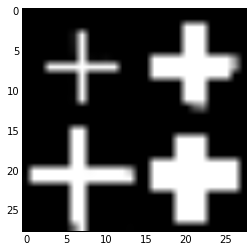

In [83]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(generator(zc).data[1].reshape(28,28),'gray')

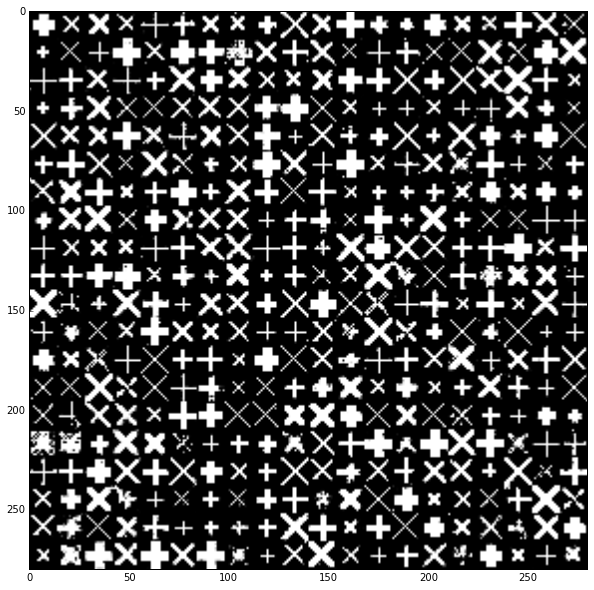

In [73]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

#z=np.random.uniform(-1, 1, (100, 62)).astype(np.float32)

c2=np.zeros((100,2))
grid_y = np.linspace(-1, 1, 10)
for j, xi in enumerate(grid_y):
    c2[j,0]=xi
        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    for i, yi in enumerate(grid_x):
        z=np.random.uniform(-1, 1, (100, 0)).astype(np.float32)
        c1=np.zeros((100,n_categorical))
        c1[:,1]=1
        c2=xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
        z_test = np.concatenate((z, c1, c2), axis=1)
        z_sample = zc
        z_sample=z_sample.astype(np.float32)
        x_decoded = generator(z_sample).data[i+j*10]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [6]:
c_categorical2 = np.zeros((160,n_categorical-12), dtype=np.float32)
for i in range(160):
        if i>=0 and i<=9:
            c_categorical2[i, :]=[0,0,0,0]
        elif i>=10 and i<=19:
            c_categorical2[i, :]=[0,0,0,1]
        elif i>=20 and i<=29:
            c_categorical2[i, :]=[0,0,1,0]
        elif i>=30 and i<=39:
            c_categorical2[i, :]=[0,1,0,0]
        elif i>=40 and i<=49:
            c_categorical2[i, :]=[1,0,0,0]
        elif i>=50 and i<=59:
            c_categorical2[i, :]=[0,0,1,1]
        elif i>=60 and i<=69:
            c_categorical2[i, :]=[0,1,0,1]
        elif i>=70 and i<=79:
            c_categorical2[i, :]=[1,0,0,1]
        elif i>=80 and i<=89:
            c_categorical2[i, :]=[0,1,1,0]
        elif i>=90 and i<=99:
            c_categorical2[i, :]=[1,0,1,0]
        elif i>=100 and i<=109:
            c_categorical2[i, :]=[1,1,0,0]
        elif i>=110 and i<=119:
            c_categorical2[i, :]=[0,1,1,1]
        elif i>=120 and i<=129:
            c_categorical2[i, :]=[1,1,0,1]
        elif i>=130 and i<=139:
            c_categorical2[i, :]=[1,0,1,1]
        elif i>=140 and i<=149:
            c_categorical2[i, :]=[1,1,1,0]
        elif i>=150 and i<=159:
            c_categorical2[i, :]=[1,1,1,1]
        

In [26]:
zs2.shape

(100L, 0L)

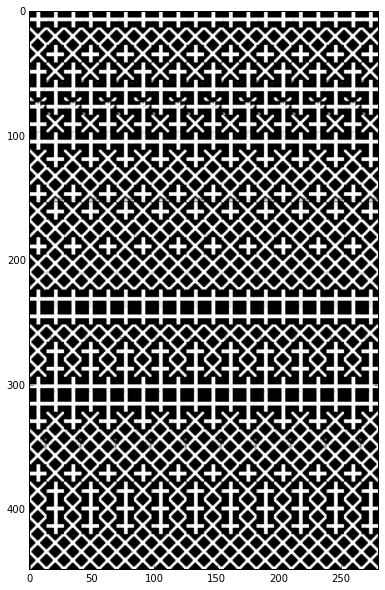

In [43]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * 16, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, 16)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
# c_categorical2 = np.zeros((batch_size,n_categorical-12), dtype=np.float32)
# for ii in range(100):
#     roll=random.randint(0,n_categorical-13)
#     c_categorical2[ii,roll]=1
# c_categorical2[0,:]=0
# c_categorical2[0,1:3]=1

c_continuous2 = xp.asarray(rnd_continuous(160, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[xi, yi]], dtype=np.float32)
        c_categorical2[0]=c_categorical2[j+10*i]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

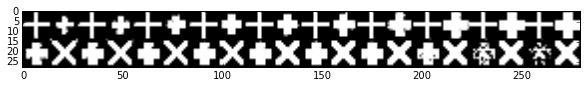

In [71]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((28, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, 16)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
# c_categorical2 = np.zeros((batch_size,n_categorical-12), dtype=np.float32)
# for ii in range(100):
#     roll=random.randint(0,n_categorical-13)
#     c_categorical2[ii,roll]=1
# c_categorical2[0,:]=0
# c_categorical2[0,1:3]=1

c_continuous2 = xp.asarray(rnd_continuous(160, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
    c_continuous2[0,:]=np.array([[yi, xi]], dtype=np.float32)
    c_categorical2[0]=c_categorical2[j]
    zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
    x_decoded = generator(zc2).data[0]
    digit = x_decoded.reshape(digit_size, digit_size)

    figure[0:28,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

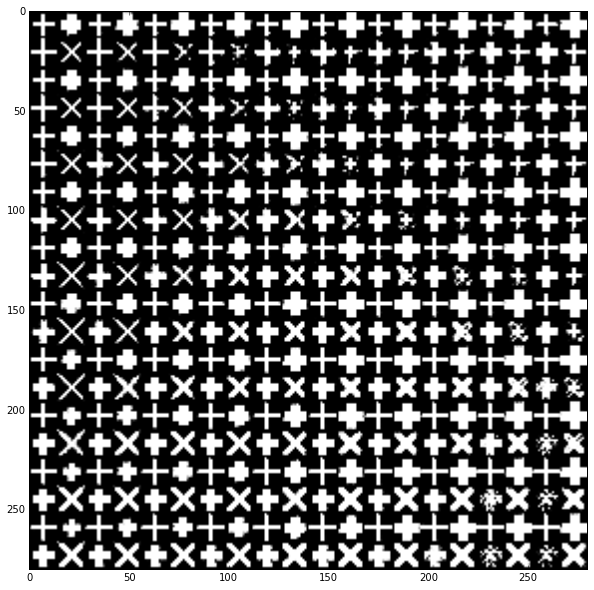

In [77]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
# c_categorical2 = np.zeros((batch_size,n_categorical-12), dtype=np.float32)
# for ii in range(100):
#     roll=random.randint(0,n_categorical-13)
#     c_categorical2[ii,roll]=1
# c_categorical2[0,:]=0
# c_categorical2[0,1:3]=1

c_continuous2 = xp.asarray(rnd_continuous(160, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[yi, xi]], dtype=np.float32)
        c_categorical2[0]=c_categorical2[0]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

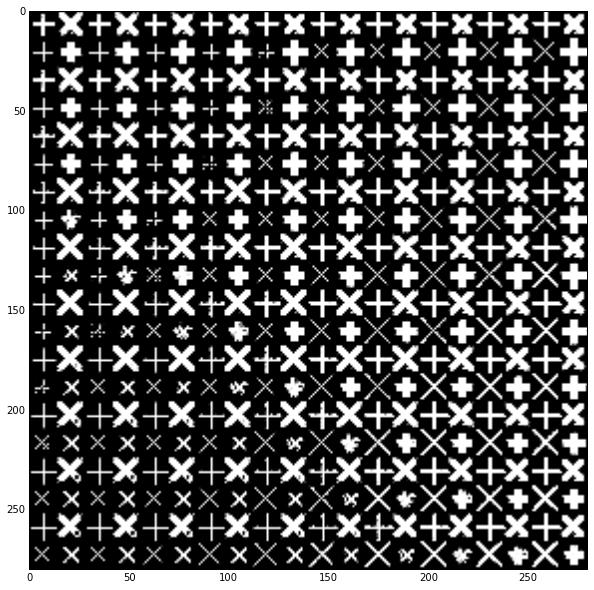

In [90]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
# c_categorical2 = np.zeros((batch_size,n_categorical-12), dtype=np.float32)
# for ii in range(100):
#     roll=random.randint(0,n_categorical-13)
#     c_categorical2[ii,roll]=1
# c_categorical2[0,:]=0
# c_categorical2[0,1:3]=1

c_continuous2 = xp.asarray(rnd_continuous(160, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[yi, xi]], dtype=np.float32)
        c_categorical2[0]=c_categorical2[40]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [79]:
c_categorical2

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  

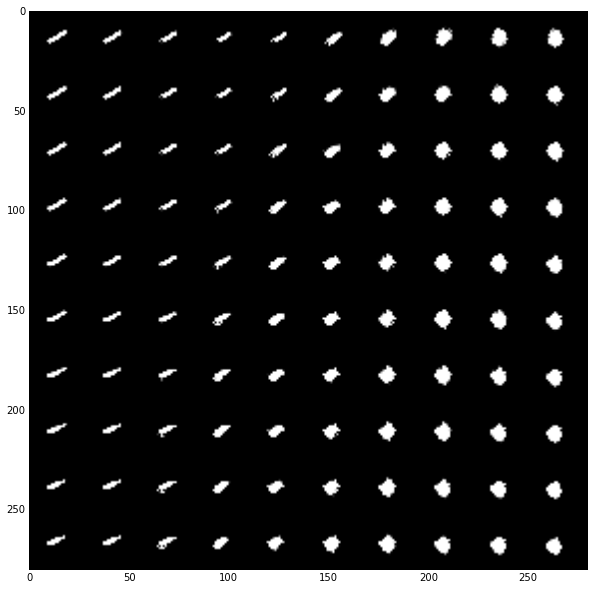

In [49]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
c_categorical2 = np.zeros((batch_size,n_categorical), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-1)
    c_categorical2[ii,roll]=1
c_categorical2[0,:]=0
c_categorical2[0,1]=1

c_continuous2 = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[-1, xi, yi]], dtype=np.float32)

        zc2 = xp.concatenate((zs2, c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[j * digit_size: (j + 1) * digit_size, i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

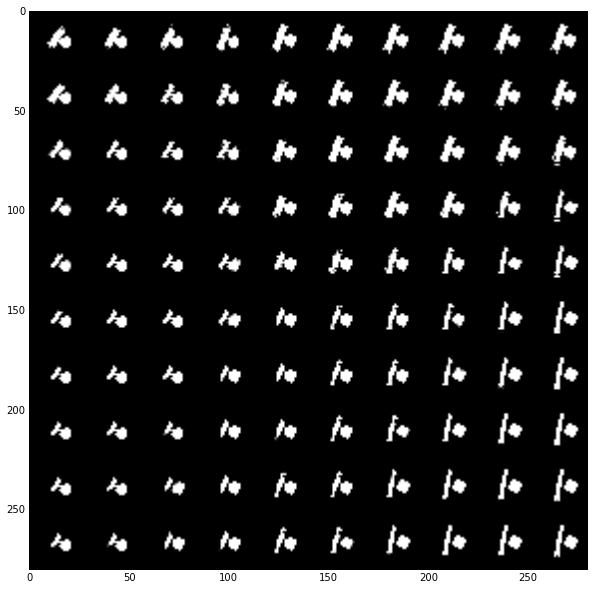

In [46]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
c_categorical2 = np.zeros((batch_size,n_categorical), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-1)
    c_categorical2[ii,roll]=1
c_categorical2[0,:]=0
c_categorical2[0,2]=1

c_continuous2 = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[-1, xi, yi]], dtype=np.float32)

        zc2 = xp.concatenate((zs2, c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[j * digit_size: (j + 1) * digit_size, i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()